# ALSSN: analysis code
This notebook contains all code we used for our analysis of the Ethereum network. There are three main parts:

1. Data collection with the Etherscan API
2. Graph analysis on all snapshots
3. Clustering

Visualization was done using the same datasets, but in Gephi.

# 1. Data collection

In [1]:
# Install packages and import
!pip install OrderedSet
!pip install numpy
!pip install pandas
!pip install matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from orderedset import OrderedSet
from time import sleep
import sys

In [7]:
def get_transactions_from_address(address,start_block,end_block):
    """
    Returns a dataframe containing all transaction of address `address` between blocks `start_block` and `end_block`. Multiple transactions between the same addresses have their values summed to decrease the number of rows. 
    """
    URL = "https://api.etherscan.io/api"

    # parameters
    api_key = "8FHTNPR8GQPAEVSRHBVDZ4TWEJQCCUB1NX"
    # defining a params dict for the parameters to be sent to the API
    PARAMS = {'module':'account','action':'txlist','address':address,'startblock':start_block,'endblock':end_block,'apikey':api_key}

    # sending get request and saving the response as response object
    try:
      r = requests.get(url = URL, params = PARAMS)
    except Exception:
      # If connection error, skip this address
      print("[Error] Error connecting to API, skipping address...")
      return pd.DataFrame({"from":[],"to":[],"value":[]}),0  

    # extracting data in json format
    data = r.json()
    if data["status"] != "0":
      print("{}".format(data["message"]))

    if len(data["result"]) > 0:
      # Load response into Dataframe
      try:
        df = pd.DataFrame(data['result'])
      except Exception:
        print("Error reading dataFrame from values, written to error.txt")
        with open("error.txt",'w') as f:
          f.write(data["result"])
          return pd.DataFrame({"from":[],"to":[],"value":[]}),0

      # Throw away some weird values
      df = df.loc[df['isError'] == "0"]
      df = df.loc[df["value"] != "0"]

      full_txn_count = len(df)

      # df = df[["timeStamp","from","to","value","gas",'isError',"gasUsed"]]
      df = df[["from","to","value"]]

      # Convert unix timestamp into something readable
      # df['timeStamp'] = df['timeStamp'].apply(lambda ts: datetime.fromtimestamp(int(ts)).strftime("%c"))

      # Group txs by (from,to) and sum value
      df['value'] = df['value'].apply(lambda x: int(x))   # Convert value str to int
      df = df.groupby(['from', 'to']).agg({'value':'sum'})
      df = df.reset_index(level=df.index.names)

      if len(df) == 10000:
        print("[Warning] 10k txs")
      return df,full_txn_count

    return pd.DataFrame({"from":[],"to":[],"value":[]}),0

In [9]:
## Get addresses with highest balance
addresses = []
with open("top_1000_addresses.txt",'r') as f:
    addresses = list(f.read().split("\n"))

In [10]:
# Starting Jan 17, a snapshot each 8 months
# Block numbers from https://blockchair.com/ethereum/
snapshot_blocklimits = []
snapshot_blocklimits.append((2912407,3100153))    # Jan '17
snapshot_blocklimits.append((4467005,4652925))    # Nov '17
snapshot_blocklimits.append((6249399,6430272))    # Sep '18
snapshot_blocklimits.append((8062293,8261511))    # Jul '19
snapshot_blocklimits.append((9976964,10176689))    # May '20
snapshot_blocklimits.append((11948960,12150244))    # Mar '21

# Only collect 100 million txs
collect_max = 1e6
collected = 0

# Get start and end block
snapshot = 0
start_block = snapshot_blocklimits[snapshot][0]
end_block = snapshot_blocklimits[snapshot][1]

output_file = "Ntxs_bf_blocks_{}_{}.txt".format(start_block,end_block)
f = open(output_file,'w',buffering=1)

queue = OrderedSet(addresses[:100])
seen_addresses = set()

while len(queue) > 0 and collected < collect_max:
    address = queue.pop()
    
    df, n = get_transactions_from_address(address,start_block,end_block)
    collected += n # Count new txs

    # Add all unseen addresses to queue
    seen_addresses.add(address)
    new_addresses = set([x for x in list(df["from"])+list(df["to"]) if x not in seen_addresses])
    for new in new_addresses:
        if len(queue) < 10000:
            queue.add(new)

    # sleep(0.25) # Wait 0.20s because we are limited to 5tx/s

    # Append dataframe in CSV format to output file
    f.write(df.to_csv(header=False,index=False))
    print("Txs: {} of {}, New txs: {}, seen addr: {}, Q = {} ({} new), ".format(collected,collect_max,len(df),len(seen_addresses),len(queue),len(new_addresses)))

Txs: 0 of 1000000.0, New txs: 0, seen addr: 1, Q = 99 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 2, Q = 98 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 3, Q = 97 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 4, Q = 96 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 5, Q = 95 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 6, Q = 94 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 7, Q = 93 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 8, Q = 92 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 9, Q = 91 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 10, Q = 90 (0 new), 
Txs: 0 of 1000000.0, New txs: 0, seen addr: 11, Q = 89 (0 new), 


KeyboardInterrupt: 

# 2. Graph analysis

In [11]:
!pip install python-igraph
!pip install matplotlib
!pip install seaborn
from igraph import *
import igraph
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import seaborn as sns
plt.style.use('bmh')

     |████████████████████████████████| 3.1 MB 522 kB/s 
  Using cached texttable-1.6.3-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 285 kB 2.2 MB/s 


## Degree distribution

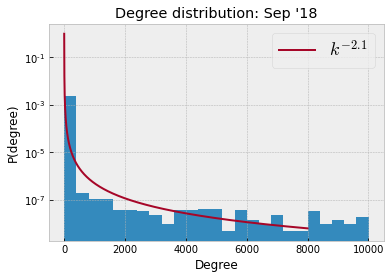

In [12]:
# jan_17.txt nov_17.txt sep_18.txt jul_19.txt may_20.txt mar_21.txt  
file = "sep_18.txt"
g = Graph.Read_Ncol("snapshots/"+file, directed=True)

degree = g.degree()

# Create log histogram
x,bins,p = plt.hist(degree, bins=25,density=True)
plt.yscale("log")
plt.title("Degree distribution: Sep '18")
plt.xlabel("Degree")
plt.ylabel("P(degree)")

# Add power law curve and create legend
exp = -2.1
plt.plot(range(1,8000),[t**(exp) for t in range(1,8000)],label=r'$k^{'+str(exp)+'}$')
plt.legend(prop={'size': 18})

plt.savefig("plots/degree_dist_{}.pdf".format(file[:-4]),bbox_inches="tight")

## Transaction volumes

jan_17.txt
nov_17.txt
sep_18.txt
jul_19.txt
may_20.txt
mar_21.txt


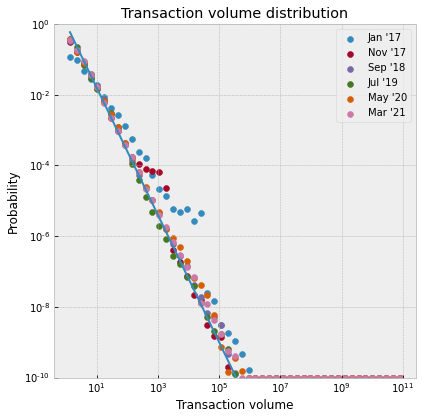

In [13]:
for i in range(6):
    file = ["jan_17.txt","nov_17.txt","sep_18.txt","jul_19.txt","may_20.txt","mar_21.txt"][i]
    label = ["Jan '17", "Nov '17", "Sep '18", "Jul '19", "May '20", "Mar '21"][i]
    if not file.endswith(".txt") or "balance" in file:
        continue

    print(file)
    # Create graph
    g = Graph.Read_Ncol("snapshots/"+file, directed=True)

    # Collect volumes in list
    vol = []
    for v in g.vs():
        vol.append(sum([g.es[e]["weight"] for e in g.incident(v,mode="out")]))
    vol = list(map(lambda x: x/1e18,vol))

    # Calculate distribution in logarithmically scaled bins
    ls = np.logspace(0,11,num=50)
    y,bins = np.histogram(vol,ls,density=True)
    x = [(ls[i]+ls[i+1])/2 for i in range(len(ls)-1)]
    
    # Give zeroes a very small positive value
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = 1e-10

    # Scatter
    plt.scatter(x,y,label=label)

# Setup loglog plot with labels and titles
plt.plot(x,[k**(-1.80) for k in x])
plt.ylim(1e-10,1e0)
plt.yscale("log")
plt.legend()
plt.xscale('log')
plt.title("Transaction volume distribution")
plt.xlabel("Transaction volume")
plt.ylabel("Probability")
fig = plt.gcf()
fig.set_size_inches(6.5, 6.5)
plt.savefig("plots/transaction_volume.pdf",bbox_inches="tight")
plt.show()

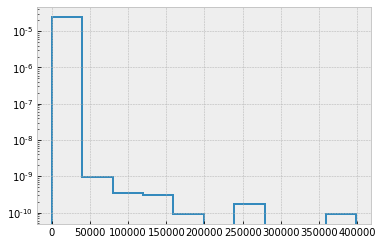

In [14]:
plt.hist(vol,density=True,histtype="step",linewidth=2)
plt.yscale("log")

## Number of whales and whales subgraph

In [15]:
# Read addresses of whales from file
whales_addr = set()
with open("top_1000_addresses.txt","r") as f:
    while True:
        line = f.readline()[:-1]
        if not line:
            print("End of file.")
            break
        whales_addr.add(line)

End of file.


In [16]:
# Build subgraph of whales and their neighborhoud + whales only

file = "mar_21.txt"

# Create graph
g = Graph.Read_Ncol("snapshots/"+file, directed=True)
whales = [n for n in g.vs() if n["name"] in whales_addr]
not_whales = [n for n in g.vs() if n["name"] not in whales_addr]

# Find whales and their neighbors + create subgraph
whales_neighborhood = set(whales)
for w in whales:
    whales_neighborhood = whales_neighborhood.union(g.neighbors(w))
whales_subgraph = g.subgraph(whales_neighborhood)
only_whales_subgraph = g.subgraph(whales)

whales_subgraph.summary()

'IGRAPH DNW- 80425 96248 -- \n+ attr: name (v), weight (e)'

In [17]:
d = whales_subgraph.degree()
spl = whales_subgraph.average_path_length()
t = whales_subgraph.transitivity_undirected()
print(spl)
print(t)

6.426098883758849
1.1097885942161532e-05


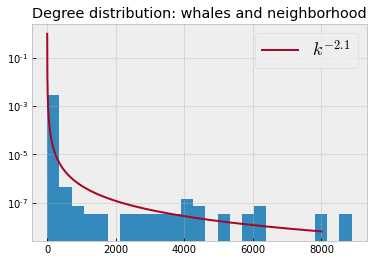

In [18]:
# Degree distribution of whales + neighborhood
x,bins,p = plt.hist(d, bins=25,density=True)
plt.yscale("log")
plt.title("Degree distribution: whales and neighborhood")

# Add power law curve and create legend
exp = -2.1
plt.plot(range(1,8000),[t**(exp) for t in range(1,8000)],label=r'$k^{'+str(exp)+'}$')
plt.legend(prop={'size': 18})

plt.savefig("plots/degree_dist_whales.pdf",bbox_inches="tight")

1.8421052631578947
0.05555555555555555
4


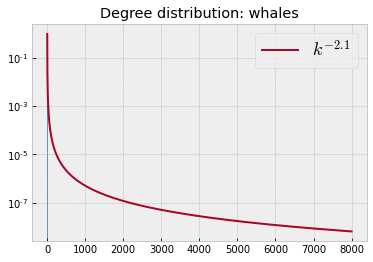

In [19]:
# Degree distribution of whales only

d = only_whales_subgraph.degree()
spl = only_whales_subgraph.average_path_length()
t = only_whales_subgraph.transitivity_undirected()
diam = only_whales_subgraph.diameter()
print(spl)
print(t)
print(diam)

# Create log histogram
x,bins,p = plt.hist(d, bins=25,density=True)
plt.yscale("log")
plt.title("Degree distribution: whales")

# Add power law curve and create legend
exp = -2.1
plt.plot(range(1,8000),[t**(exp) for t in range(1,8000)],label=r'$k^{'+str(exp)+'}$')
plt.legend(prop={'size': 18})

plt.savefig("plots/degree_dist_whales_only.pdf",bbox_inches="tight")

In [24]:
# Transaction volume of whales

whales_addr = set()
with open("top_1000_addresses.txt","r") as f:
    while True:
        line = f.readline()[:-1]
        if not line:
            print("End of file.")
            break
        whales_addr.add(line)

file = "mar_21.txt"
g = Graph.Read_Ncol("snapshots/"+file, directed=True)
whales_vol = 0
nonwhales_vol = 0
whales_trades = 0
nonwhales_trades = 0
for e in g.es():
    if g.vs()[e.source]["name"] in whales_addr:
        whales_vol += e["weight"]
        whales_trades += 1 
    else:
        nonwhales_vol += e["weight"]
        nonwhales_trades += 1

print("Whales: {:0.3e} wei, non-whales: {:0.3e} wei, whales account for {:.2f}%".format(whales_vol,nonwhales_vol, whales_vol/(whales_vol+nonwhales_vol)))
print("Whales: {:0.3e} trades, non-whales: {:0.3e} trades, whales account for {:.2f}%".format(whales_trades,nonwhales_trades, whales_trades/(whales_trades+nonwhales_trades)))

End of file.
Whales: 2.337e+24 wei, non-whales: 6.923e+24 wei, whales account for 0.25%
Whales: 5.356e+04 trades, non-whales: 6.479e+05 trades, whales account for 0.08%


## Transitivity

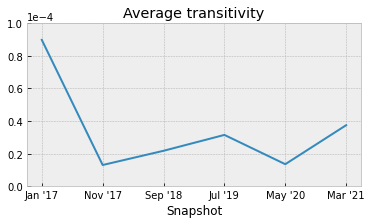

In [25]:
# Transitivity
x = range(6)
y = [8.979131831293448e-05,1.305370093077275e-05,2.1773902094144812e-05,3.150763008229304e-05,1.355142321454942e-05,3.747405255138334e-05]
plt.plot(x,y)
plt.title("Average transitivity")
plt.xlabel("Snapshot")
plt.xticks(range(6),["Jan '17", "Nov '17", "Sep '18", "Jul '19", "May '20", "Mar '21"])
plt.ylim((0,1e-4))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
f = plt.gcf()
f.set_size_inches(6,3)
plt.savefig("plots/transitivity.pdf",bbox_inches="tight")

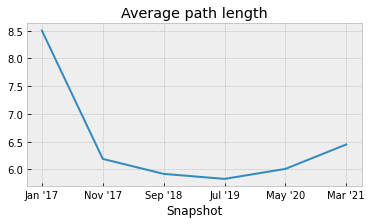

In [26]:
# Average geodesic path length

x = range(6)
y = [8.5, 6.19, 5.92, 5.83, 6.01, 6.45]
plt.plot(x,y)
plt.title("Average path length")
plt.xlabel("Snapshot")
plt.xticks(range(6),["Jan '17", "Nov '17", "Sep '18", "Jul '19", "May '20", "Mar '21"])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
f = plt.gcf()
f.set_size_inches(6,3)
plt.savefig("plots/average_path.pdf",bbox_inches="tight")

In [ ]:
# Some other metrics (these take long to calculate, therefore I saved the results in comments)

file = "mar_21.txt"
# Create graph
for file in os.listdir("snapshots"):
    g = Graph.Read_Ncol("snapshots/"+file, directed=True)
    print("{} nodes, {} edges".format(len(g.vs()),len(g.es())))
    print(file)
    print("transitivity: {}".format(g.transitivity_undirected()))
    print("diameter: {}".format(g.diameter()))
    print("avg path length: {}".format(g.average_path_length()))

# jan_17.txt
# transitivity: 8.979131831293448e-05
# diameter: 38
# avg path length: 8.500705048368546
# nov_17.txt
# transitivity: 1.305370093077275e-05
# diameter: 43
# avg path length: 8.500705048368546
# sep_18.txt
# transitivity: 2.1773902094144812e-05
# diameter: 21
# avg path length: 5.928087756391317
# jul_19.txt
# transitivity: 3.150763008229304e-05
# diameter: 19
# avg path length: 5.838516279371158
# may_20.txt
# transitivity: 1.355142321454942e-05
# diameter: 24
# avg path length: 6.016498490810574
# mar_21.txt
# transitivity: 3.747405255138334e-05
# diameter: 22
# avg path length: 6.458825138104836

# 3. Clustering

In [27]:
!pip install python-igraph
!pip install matplotlib
!pip install seaborn
from igraph import *
import igraph
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import seaborn as sns

In [28]:
# jan_17.txt nov_17.txt sep_18.txt jul_19.txt may_20.txt mar_21.txt  
file = "mar_21.txt"
g = Graph.Read_Ncol("snapshots/"+file, directed=True)

In [30]:
# Create three clusterings for each snapshot

# jan_17.txt nov_17.txt sep_18.txt jul_19.txt may_20.txt mar_21.txt  
num_eigenvector = []
mod_eigenvector = []
num_louvain = []
mod_louvain = []
num_leiden = []
mod_leiden = []

i=1

for file in ["jan_17.txt", "nov_17.txt", "sep_18.txt", "jul_19.txt", "may_20.txt", "mar_21.txt"]:  
    g = Graph.Read_Ncol(file, directed=True)
    print("{}, {}/6".format(file,i))
    
    lead = g.community_leading_eigenvector(clusters=100)
    num_eigenvector.append(len(lead))
    mod_eigenvector.append(lead.modularity)

    lvn = g.as_undirected().community_multilevel(weights=None)
    num_louvain.append(len(lvn))
    mod_louvain.append(lvn.modularity)

    leiden = g.as_undirected().community_leiden(objective_function="modularity",n_iterations=10)
    num_leiden.append(len(leiden))
    mod_leiden.append(leiden.modularity)
    
    i+=1

jan_17.txt, 1/6
/home/quinten/.anaconda3/envs/CV/lib/python3.6/site-packages/igraph/__init__.py:1280: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  self, clusters, **kwds
nov_17.txt, 2/6
sep_18.txt, 3/6
jul_19.txt, 4/6
may_20.txt, 5/6
mar_21.txt, 6/6


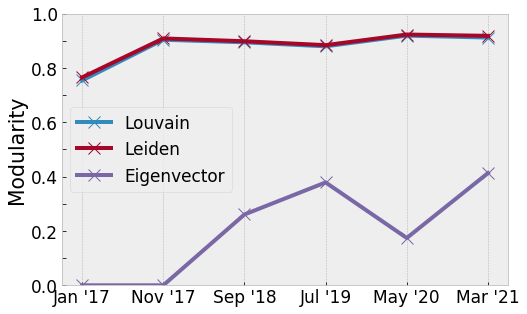

In [31]:
# Plot modularity
plt.rcParams.update({'font.size': 17})
plt.plot(range(6),mod_louvain,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.plot(range(6),mod_leiden,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.plot(range(6),mod_eigenvector,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.legend(labels=["Louvain","Leiden","Eigenvector"])
plt.yticks([t/10 for t in range(0,11)],[str(x) if 100*x%20==0 else "" for x in[t/10 for t in range(0,11)]])
plt.grid(axis="y")
plt.xticks(range(6),["Jan '17", "Nov '17", "Sep '18", "Jul '19", "May '20", "Mar '21"])
plt.ylabel("Modularity")
plt.ylim(0,1)
f = plt.gcf()
f.set_size_inches(8,5)
plt.savefig("plots/clusters_modularity.pdf",bbox_inches="tight")

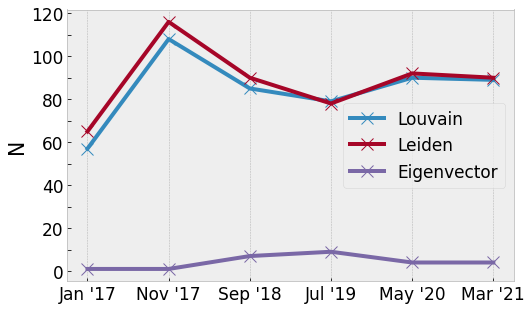

In [32]:
# Plot no. clusters
plt.rcParams.update({'font.size': 17})
plt.plot(range(6),num_louvain,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.plot(range(6),num_leiden,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.plot(range(6),num_eigenvector,linestyle="-",marker="x",linewidth=4,markersize=12)
plt.legend(labels=["Louvain","Leiden","Eigenvector"])
plt.xticks(range(6),["Jan '17", "Nov '17", "Sep '18", "Jul '19", "May '20", "Mar '21"])
plt.ylabel("N")
plt.yticks(range(0,130,10),[str(x) if x%20==0 else "" for x in range(0,130,10) ])
plt.grid(axis="y")
f = plt.gcf()
f.set_size_inches(8,5)
plt.savefig("plots/clusters_num.pdf",bbox_inches="tight")